In [1]:
# Paquetes importados para análisis preliminar
import numpy as np # manejo de matrices
import pandas as pd # importación de archivos de excel
import matplotlib.pyplot as plt # graficación
import os # acceso al sistema operativo

In [2]:
# Se importan librerías estadísticas y de graficación avanzada
import seaborn as sns # para graficación más compleja
import statsmodels.api as sm # para la evaluación del ajuste el modelo de ANOVA
from statsmodels.formula.api import ols # para la construcción del modelo de ANOVA

El presente cuaderno Jupyter busca identificar la vida útil de los electrodos de filamento paladizados. Busca funcionar como validación de la prueba de precisión por medio de un ANOVA.

# Funciones a utilizar

In [3]:
def Lectura(file_dir,n):
    '''
    Función que recibe un directorio que contiene carpetas por cada día que se ejecutaron las mediciones y extrae los últimos datos del Potencial de los archivos Excel
    Input
    ----------------
    file_dir: el direcctorio en el cual se encuentran las capetas de cada día de medición.
    n: número de datos a extraer
    
    Output
    ----------------
    datos: un diccionario con los datos separados por día de medición.
    '''
    # utilizando os.listdir se hace una lista de los directorios que se encuentran en el directorio file_dir
    días=os.listdir(file_dir)
    # se define un diccionario para el almacenamiento de la información
    datos={}
    # se itera sobre la lista de directorios
    for iDía in días:
        archivos=os.listdir(os.path.join(file_dir,iDía)) # se hace una lista con los nombres de los archivos en el directorio
        potenciales= [] # {} # se crea una lista para el almacenamiento de los datos

        # rep0=None

        # Se inicia una iteración sobre los archivos que están en ese día
        for iArchivo in archivos:
            df=pd.read_excel(os.path.join(os.path.join(file_dir,iDía),iArchivo),skiprows=1,header=0,sheet_name="Datos_Crudos") # se realiza la lectura del archivo de excel
            potenciales.append(df['POTENCIAL (V)'][-n:].values) # se añaden los últimos 300 datos del potencial a la lista que se creó anteriormente

        datos[iDía]=potenciales # se crea una entrada con el Día como llave en el diccionario creado al inicio.
    return datos

In [4]:
def Graficación(datos):
    '''
    Función que realiza gráficas de caja y bigotes por día de medición.
    Input
    ------------
    datos: diccionario que viene dado de la forma que entrega la función Lectura.
    
    Output:
    ------------
    gráficas de cada día de medición
    '''
    for iKey in datos.keys(): # se itera por el número de días
        día=datos[iKey] # se toma el día
        plt.figure(figsize=(15,10)) # tamaño de la figura
        plt.xlabel("Corrida") # nombre del eje x
        plt.ylabel("Potencial (V)") # nombre del eje y
        plt.boxplot(np.array(día).T) # graficación de los datos
        plt.plot(np.linspace(0,len(np.array(día))+1,len(np.array(día).T)),np.zeros(len(np.array(día).T)),color="blue") # 
        plt.plot(np.linspace(0,len(np.array(día))+1,len(np.array(día).T)),np.zeros(len(np.array(día).T))+10e-6,color="orange")
        plt.plot(np.linspace(0,len(np.array(día))+1,len(np.array(día).T)),np.zeros(len(np.array(día).T))+-10e-6,color="orange")
        plt.plot(np.linspace(0,len(np.array(día))+1,len(np.array(día).T)),np.zeros(len(np.array(día).T))+50e-6,color="red")
        plt.plot(np.linspace(0,len(np.array(día))+1,len(np.array(día).T)),np.zeros(len(np.array(día).T))+-50e-6,color="red")
        plt.title(iKey)
        plt.show()

# Material del Merck

In [5]:
# Se define el directorio en que se encuentran los datos
file_dir=r"Datos\Vida útil de electrodos\Merck"

In [6]:
# se realiza la lectura
datosm=Lectura(file_dir,600)

A continuación, se realiza la graficación de los datos:

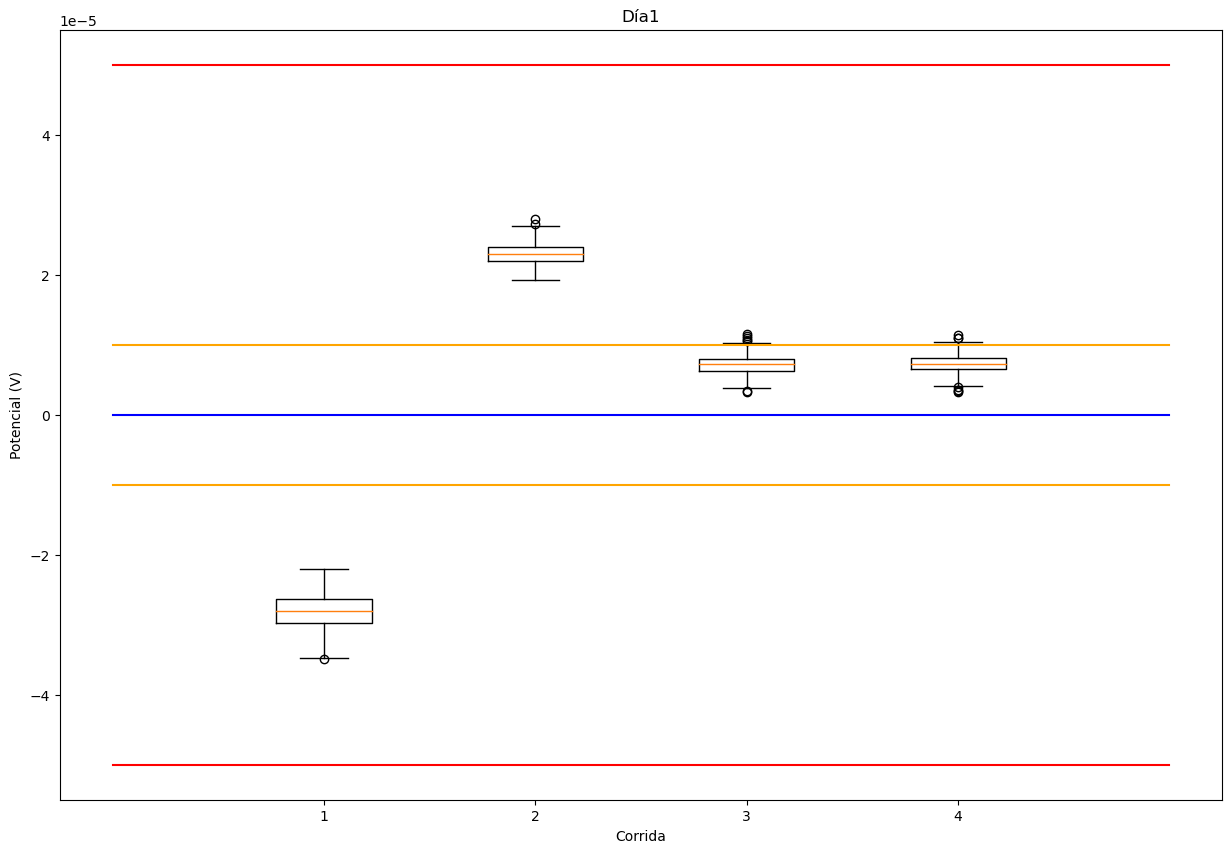

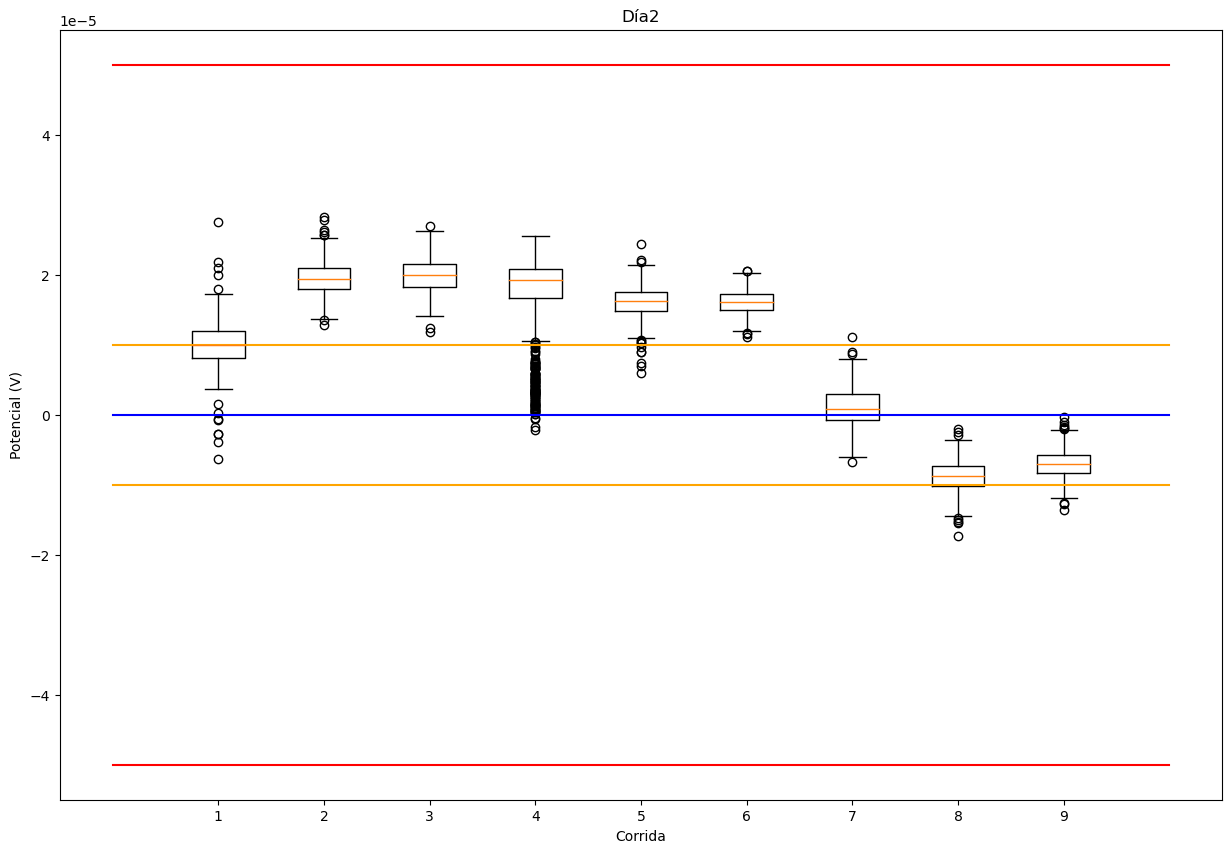

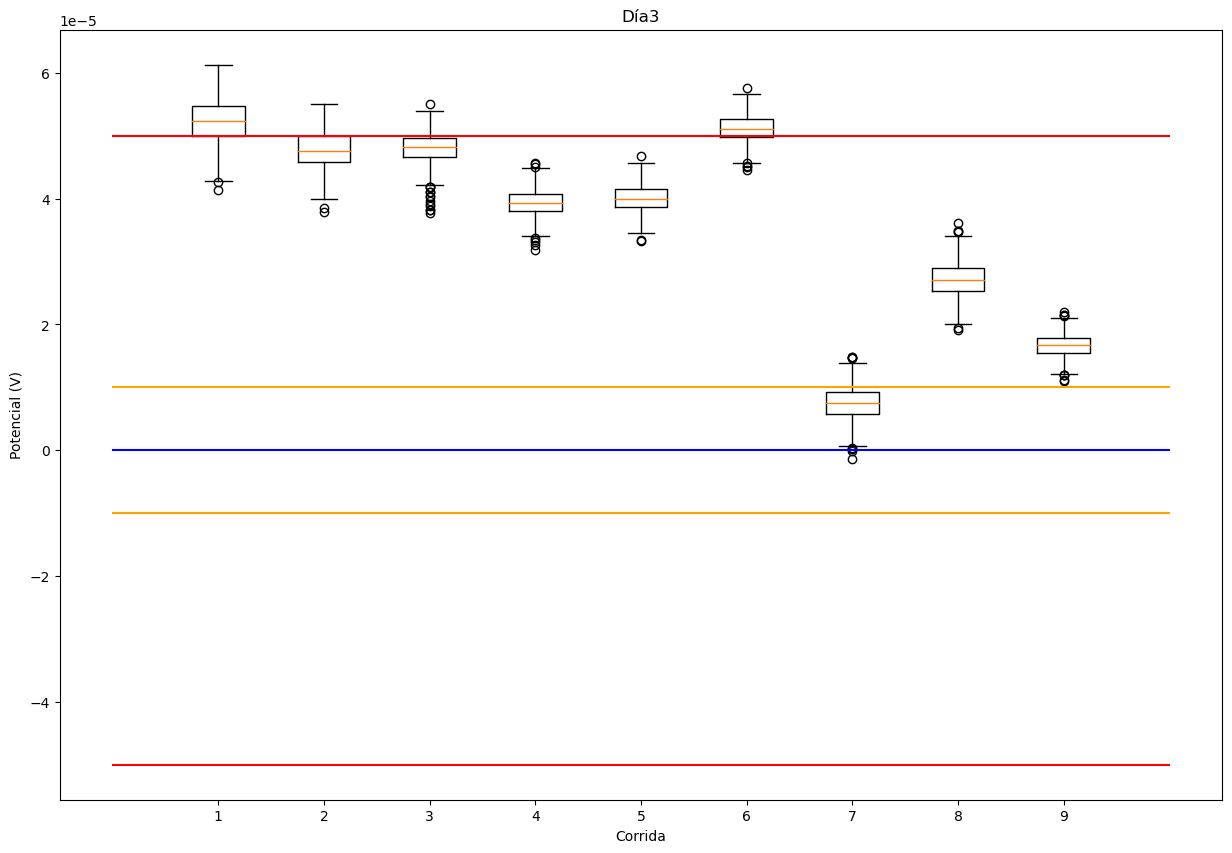

In [7]:
Graficación(datosm)

## ANOVA

In [8]:
día=["Día2","Día3"]
prueba=["1","2","3"]
corrida=["1","2","3"]
diseño=[(x,y,z) for x in día for y in prueba for z in corrida]
exp_df = pd.DataFrame(diseño,columns=['Día',"Prueba",'Corrida'])

In [9]:
# Se asignan las medias del potencial de cada corrida al respectivo ensayo
n=0 # contador de iteraciones totales, funciona para definir la posición del valor en el Datafram
for iDía in datosm.keys(): # se itera por día
    if iDía=="Día1":
        pass
    else:
        día=datosm[iDía] 
        for iCorrida in range(len(día)): # se itera por corrida en un día
            exp_df.at[n,"PotencialMedio"]=np.abs(día[iCorrida]).mean() # se agrega en la columna Potencial Medio (V) el valor de la media
            n+=1 # se suma 1 al contador

In [10]:
exp_df

Día Prueba Corrida  PotencialMedio
0   Día2      1       1        0.000010
1   Día2      1       2        0.000020
2   Día2      1       3        0.000020
3   Día2      2       1        0.000017
4   Día2      2       2        0.000016
5   Día2      2       3        0.000016
6   Día2      3       1        0.000002
7   Día2      3       2        0.000009
8   Día2      3       3        0.000007
9   Día3      1       1        0.000052
10  Día3      1       2        0.000048
11  Día3      1       3        0.000048
12  Día3      2       1        0.000039
13  Día3      2       2        0.000040
14  Día3      2       3        0.000051
15  Día3      3       1        0.000007
16  Día3      3       2        0.000027
17  Día3      3       3        0.000017

In [11]:
# Se realiza la gráfica de caja y bigotes para comparar la forma en la que se comportan las pruebas por día de uso
plt.figure(figsize=(15,10))
sns.boxplot(x="Día", y="PotencialMedio", hue="Prueba", data=exp_df, palette="Set3") 
plt.show()

In [12]:
# Se realiza el ANOVA
model = ols('PotencialMedio ~ C(Día) + C(Corrida) + C(Prueba)', data=exp_df).fit() # modelo reducido
anova_table = sm.stats.anova_lm(model, typ=2) # tabla ANOVA
anova_table

sum_sq    df          F    PR(>F)
C(Día)      2.524513e-09   1.0  46.095361  0.000019
C(Corrida)  1.058432e-10   2.0   0.966301  0.408220
C(Prueba)   1.604735e-09   2.0  14.650516  0.000602
Residual    6.572062e-10  12.0        NaN       NaN

# Material Sigma Aldrich

In [13]:
file_dir=r"Datos\Vida útil de electrodos\Sigma Aldrich"
datoss=Lectura(file_dir,600)

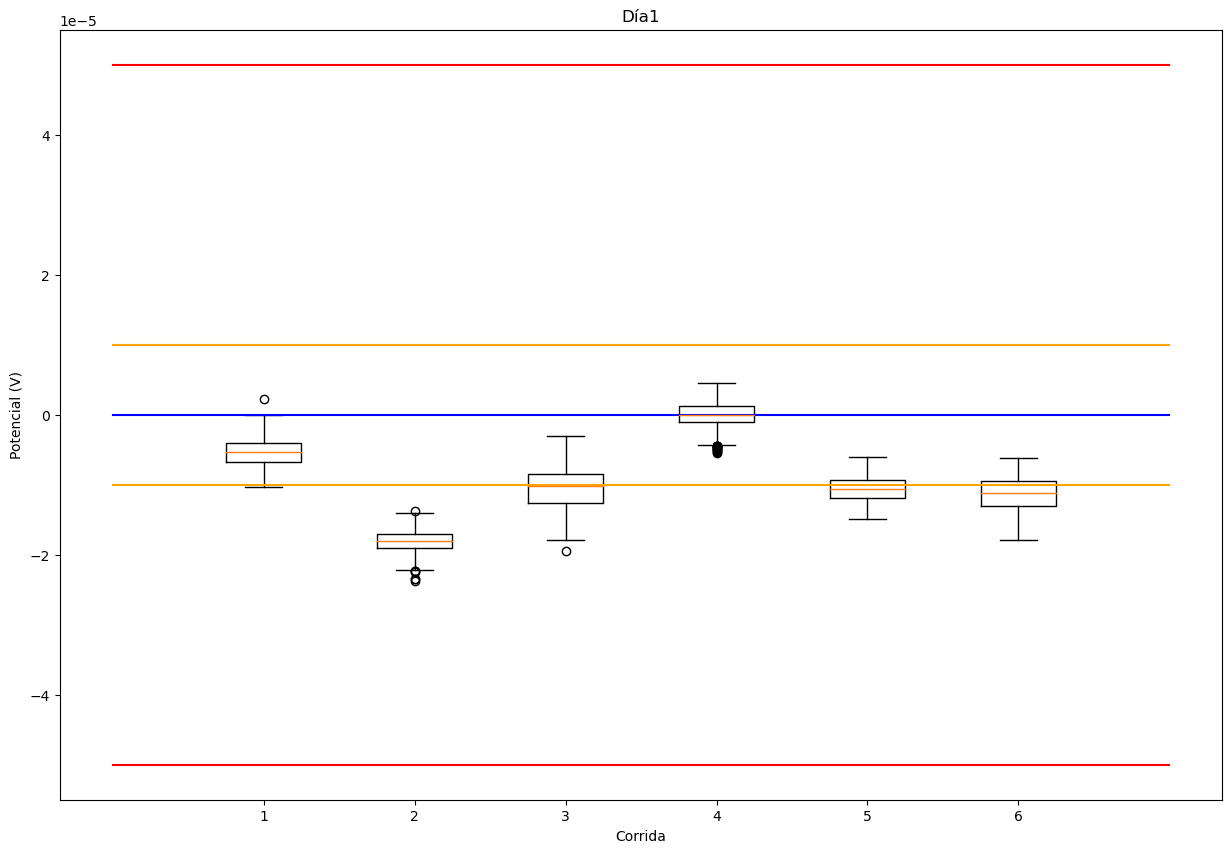

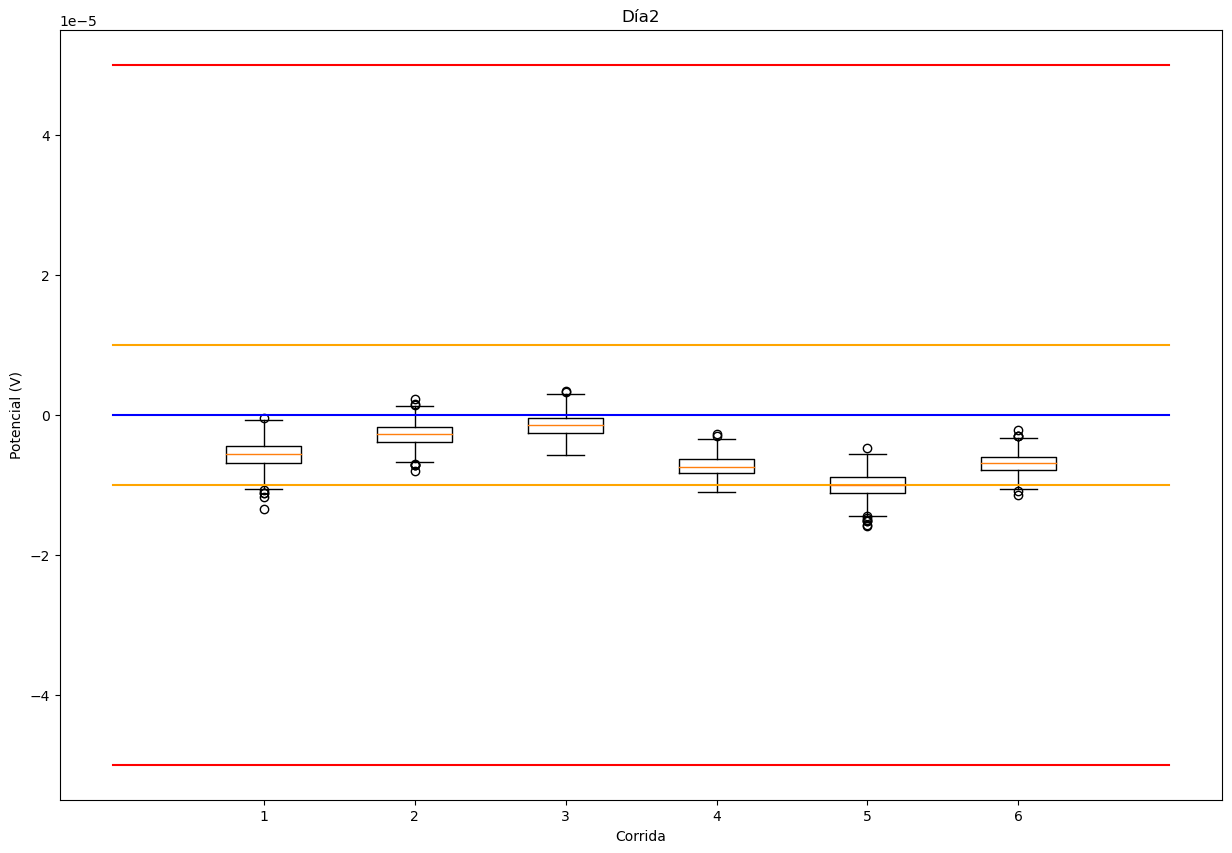

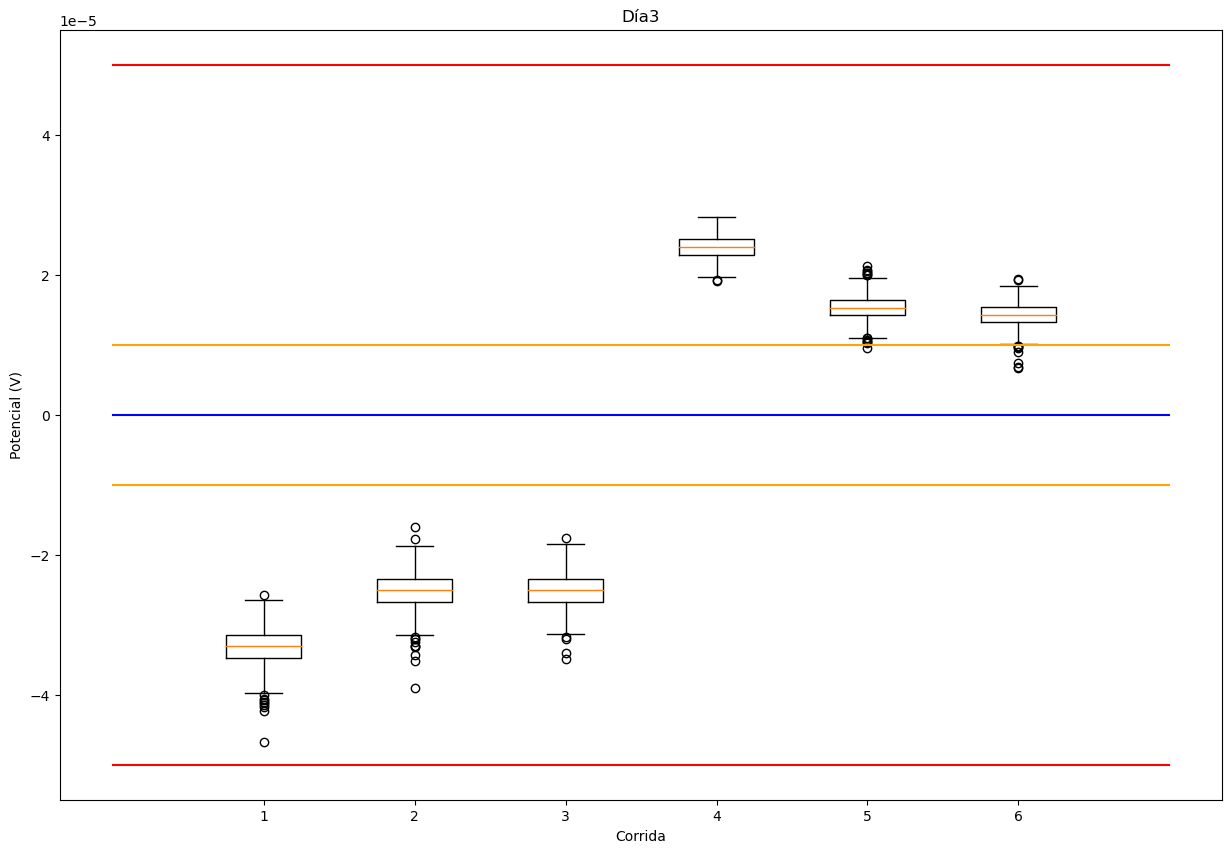

In [14]:
Graficación(datoss)

## ANOVA
Ahora, se realizará una prueba ANOVA para evaluar la precisión del material de Sigma Aldrich

Se definen los factores a evaluar: Día, Prueba y Corrida. Recordando que, Día corresponde al día de uso tras una única paladización, Prueba corresponde al uso tras un cambio en la disolución y Corrida a un evento de medición en una prueba determinada.

In [15]:
día=["Día1","Día2","Día3"]
prueba=["1","2"]
corrida=["1","2","3"]
diseño=[(x,y,z) for x in día for y in prueba for z in corrida]
exp_df = pd.DataFrame(diseño,columns=['Día',"Prueba",'Corrida'])

In [16]:
# Se asignan las medias del potencial de cada corrida al respectivo ensayo
n=0 # contador de iteraciones totales, funciona para definir la posición del valor en el Datafram
for iDía in datoss.keys(): # se itera por día
    día=datoss[iDía] 
    for iCorrida in range(len(día)): # se itera por corrida en un día
        exp_df.at[n,"PotencialMedio"]=np.abs(día[iCorrida]).mean() # se agrega en la columna Potencial Medio (V) el valor de la media
        n+=1 # se suma 1 al contador

In [17]:
exp_df

Día Prueba Corrida  PotencialMedio
0   Día1      1       1        0.000005
1   Día1      1       2        0.000018
2   Día1      1       3        0.000010
3   Día1      2       1        0.000001
4   Día1      2       2        0.000011
5   Día1      2       3        0.000011
6   Día2      1       1        0.000006
7   Día2      1       2        0.000003
8   Día2      1       3        0.000002
9   Día2      2       1        0.000007
10  Día2      2       2        0.000010
11  Día2      2       3        0.000007
12  Día3      1       1        0.000033
13  Día3      1       2        0.000025
14  Día3      1       3        0.000025
15  Día3      2       1        0.000024
16  Día3      2       2        0.000015
17  Día3      2       3        0.000014

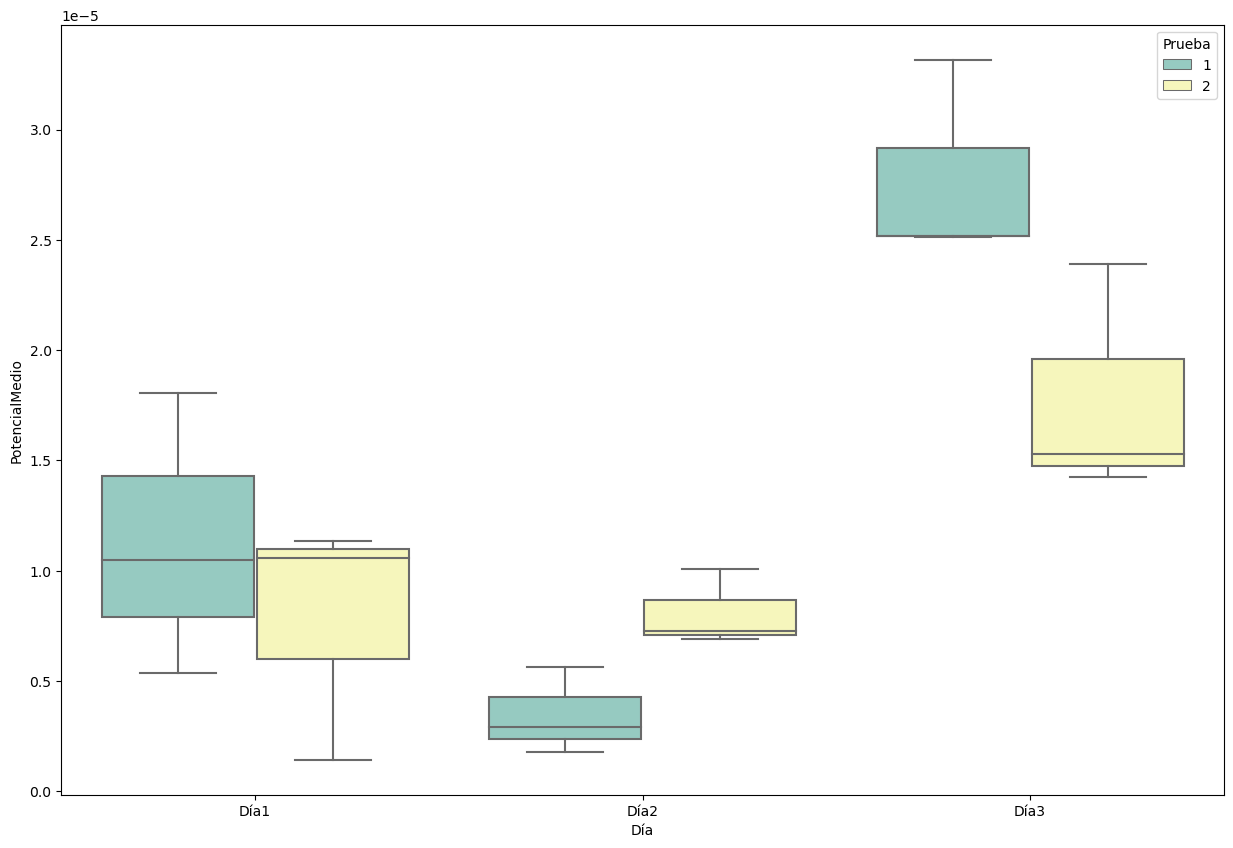

In [18]:
# Se realiza la gráfica de caja y bigotes para comparar la forma en la que se comportan las pruebas por día de uso
plt.figure(figsize=(15,10))
sns.boxplot(x="Día", y="PotencialMedio", hue="Prueba", data=exp_df, palette="Set3") 
plt.show()

In [19]:
# Se realiza el ANOVA
model = ols('PotencialMedio ~ C(Día) + C(Prueba) + C(Día):C(Prueba)', data=exp_df).fit() # modelo reducido
anova_table = sm.stats.anova_lm(model, typ=2) # tabla ANOVA
anova_table

sum_sq    df          F    PR(>F)
C(Día)            9.621095e-10   2.0  22.558041  0.000086
C(Prueba)         3.954125e-11   1.0   1.854203  0.198313
C(Día):C(Prueba)  1.617861e-10   2.0   3.793307  0.052885
Residual          2.559024e-10  12.0        NaN       NaN

Se observa que si bien el día no es un factor significativo en sí mismo su interacción con la prueba en la que se realiza la medición sí lo es, teniendo efectos más críticos los terceros días. Además, el segundo día es el que presenta mejor repetibilidad entre pruebas así como mayor cercanía al valor de cero.

# Material J.T. Baker

Este es el material que a una concentración de $0.01\textrm{ mol/kg}$ funciona como búfer de pH 9.

In [20]:
file_dir=r"Datos\Vida útil de electrodos\J.T. Baker"
datosj=Lectura(file_dir,100)

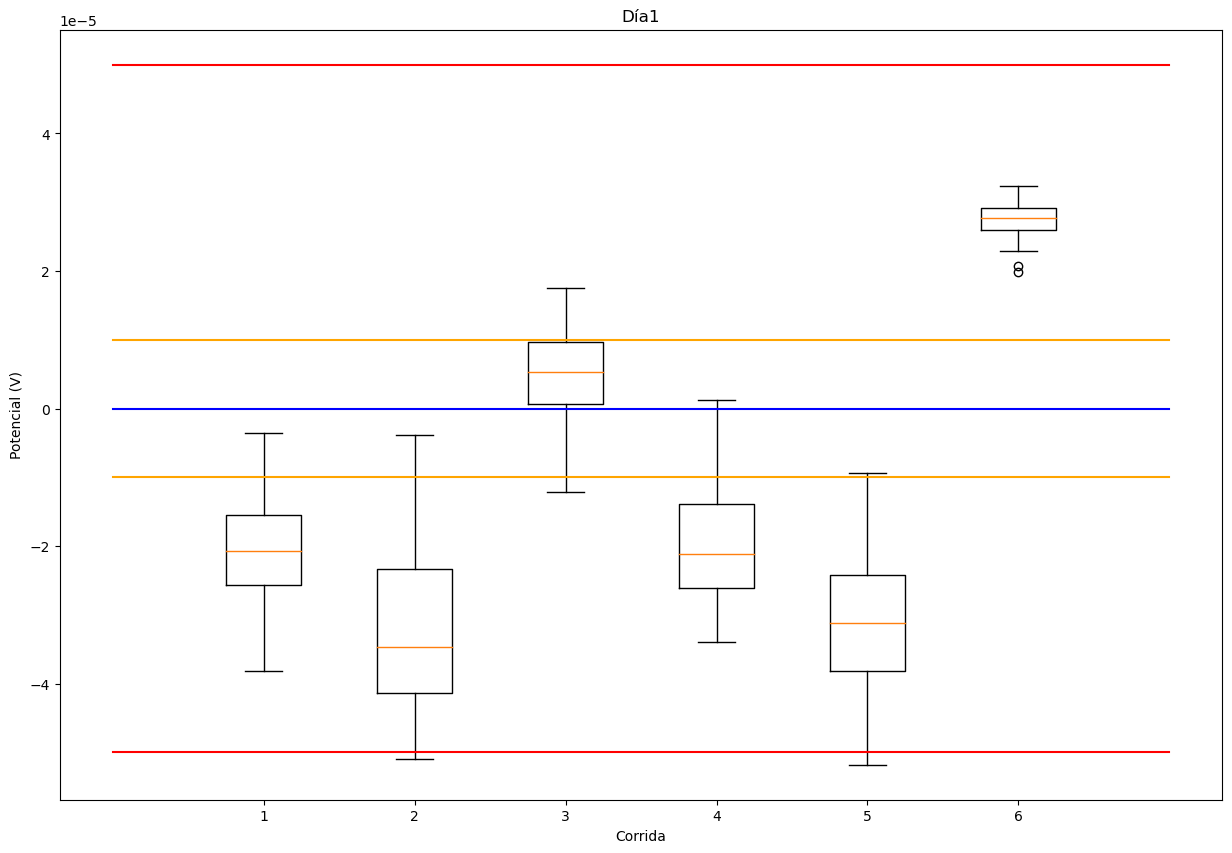

In [21]:
Graficación(datosj)

## ANOVA

In [22]:
día=["Día1","Día2","Día3","Día4"]
prueba=["1","2"]
corrida=["1","2","3"]
diseño=[(x,y,z) for x in día for y in prueba for z in corrida]
exp_df = pd.DataFrame(diseño,columns=['Día',"Prueba",'Corrida'])

In [23]:
# Se asignan las medias del potencial de cada corrida al respectivo ensayo
n=0 # contador de iteraciones totales, funciona para definir la posición del valor en el Datafram
for iDía in datosj.keys(): # se itera por día
    día=datosj[iDía] 
    for iCorrida in range(len(día)): # se itera por corrida en un día
        exp_df.at[n,"PotencialMedio"]=día[iCorrida].mean() # se agrega en la columna Potencial Medio (V) el valor de la media
        n+=1 # se suma 1 al contador

In [24]:
exp_df

Día Prueba Corrida  PotencialMedio
0   Día1      1       1   -2.050200e-05
1   Día1      1       2   -3.191700e-05
2   Día1      1       3    4.606000e-06
3   Día1      2       1   -1.997400e-05
4   Día1      2       2   -3.123700e-05
5   Día1      2       3    2.753500e-05
6   Día2      1       1   -9.473000e-06
7   Día2      1       2   -1.682300e-05
8   Día2      1       3    1.359000e-06
9   Día2      2       1    2.290000e-07
10  Día2      2       2   -8.184000e-06
11  Día2      2       3    2.452400e-05
12  Día3      1       1    2.524900e-05
13  Día3      1       2   -2.167600e-05
14  Día3      1       3   -3.545600e-05
15  Día3      2       1    2.216600e-05
16  Día3      2       2   -4.433000e-06
17  Día3      2       3   -4.143800e-05
18  Día4      1       1    1.630400e-05
19  Día4      1       2    2.377800e-05
20  Día4      1       3    2.321200e-05
21  Día4      2       1    2.384700e-05
22  Día4      2       2    2.611300e-05
23  Día4      2       3    2.566900e-05

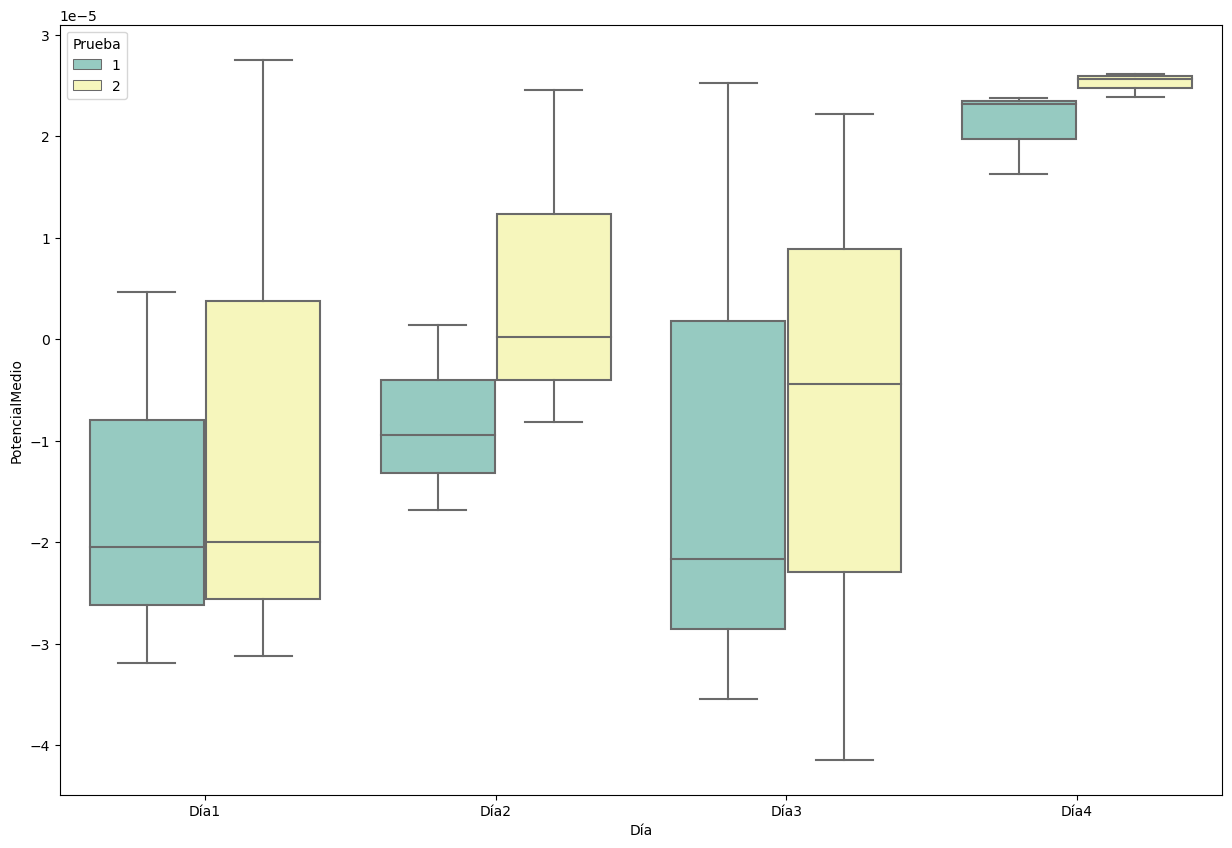

In [25]:
# Se realiza la gráfica de caja y bigotes para comparar la forma en la que se comportan las pruebas por día de uso
plt.figure(figsize=(15,10))
sns.boxplot(x="Día", y="PotencialMedio", hue="Prueba", data=exp_df, palette="Set3") 
plt.show()

In [26]:
# Se realiza el ANOVA
model = ols('PotencialMedio ~ C(Prueba) + C(Día) + C(Corrida)', data=exp_df).fit() # modelo reducido
anova_table = sm.stats.anova_lm(model, typ=1) # tabla ANOVA
anova_table

df        sum_sq       mean_sq         F    PR(>F)
C(Prueba)    1.0  3.092857e-10  3.092857e-10  0.773817  0.391304
C(Día)       3.0  4.594551e-09  1.531517e-09  3.831779  0.029000
C(Corrida)   2.0  8.092005e-10  4.046002e-10  1.012290  0.384271
Residual    17.0  6.794700e-09  3.996882e-10       NaN       NaN